In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit


from trajectory import Atom, Topology, FakeTrajectory

from os import listdir
from os.path import isfile, join

In [3]:
xs, ys = [[],[]], [[],[]]

phases = ["Lo", "Ld"]
LO = 0
LD = 1

for i in range(2):
    phase = phases[i]
    
    path = "trajectories/%s/" % phase
    files = [f for f in listdir(path) if isfile(join(path, f)) and not f[0] == '.' ] 
    
    for file in files:
#         print("Importing %s" % path+file)
        x, y = np.loadtxt(path + file, unpack=True)
        xs[i].append(x)
        ys[i].append(y)
        print("Imported %d timesteps of data." % len(x))
    
# x, y = np.loadtxt(path + files[1], unpack=True)
# xs.append(x)
# ys.append(y)

Imported 22683 timesteps of data.
Imported 47401 timesteps of data.
Imported 24701 timesteps of data.
Imported 24648 timesteps of data.
Imported 28300 timesteps of data.
Imported 21450 timesteps of data.
Imported 95900 timesteps of data.
Imported 68800 timesteps of data.
Imported 28801 timesteps of data.
Imported 31801 timesteps of data.
Imported 22000 timesteps of data.
Imported 18701 timesteps of data.
Imported 19401 timesteps of data.
Imported 13600 timesteps of data.
Imported 10001 timesteps of data.
Imported 12344 timesteps of data.
Imported 18401 timesteps of data.
Imported 31689 timesteps of data.
Imported 44400 timesteps of data.
Imported 25099 timesteps of data.


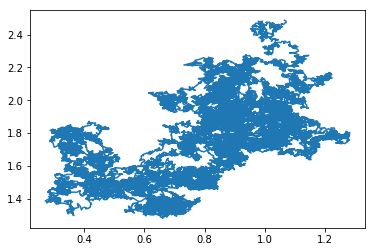

In [4]:
plt.plot(xs[1][9], ys[1][9])

# Find the longest trajectory
maxlen = min([len(x) for x in xs[0]])
# print(minlen)

# Find the MSD for each phase

21450
21450
21450
21450
21450
21450
21450
21450
21450
21450
21450


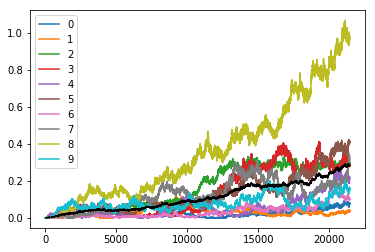

In [5]:
# MSDs = np.array(shape=(10,maxlen))

Lo_minlen = min([len(x) for x in xs[LO]])
Ld_minlen = min([len(x) for x in xs[LD]])

MSDs = [[],[]]

time_average_step = 2


# For each phase...
for i in range(2):
    
    # Truncate all trajectories to the shortest trajectory in this
    #   phase.
    minlen = min([len(x) for x in xs[i]])
    
    _MSDs = np.zeros(shape=(9,minlen))
    
    # For each trajectory...
    for t in range(10):
#         if not t == 2:
#             continue
#     with t as 1:
        
        # List of MSDs in time for this trajectory
        _MSD = []
        
        start_x = xs[i][t][0]
        start_y = ys[i][t][0]
        
        # For each timestep...
        for p in range(len(xs[i][t])):
            
            # Calculate this MSD
            curr_x = xs[i][t][p] - start_x
            curr_y = ys[i][t][p] - start_y
            MSD = curr_x**2 + curr_y**2
            
            _MSD.append(MSD)
            
        # Time average
#         for 
        
        MSDs[i].append(np.array(_MSD[:minlen]))

        
# Time-average the MSDs for each phase


# Ensemble average the MSDs for each phase
#Subdiffusion happens below 1ms, which corresponds to 50 timesteps (20 microseconds each)
Lo_avg = np.mean(MSDs[LO], axis=0)#[:50/time_average_step]
Ld_avg = np.mean(MSDs[LD], axis=0)#[:50/time_average_step]

for i, traj in enumerate(MSDs[LO]):
    print(len(traj))
    plt.plot(traj, label=i)
plt.plot(Lo_avg, 'k--')
plt.legend()
print(len(Lo_avg))

In [6]:
len(MSDs[LO][0])

21450

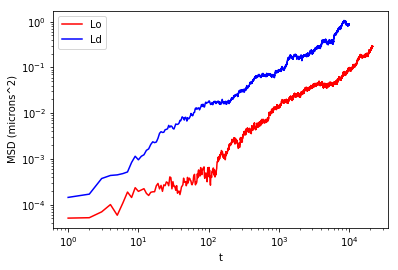

In [7]:
plt.loglog(Lo_avg, 'r-', label="Lo")
plt.loglog(Ld_avg, 'b-', label="Ld")

plt.xlabel("t")
plt.ylabel("MSD (microns^2)")
plt.legend()

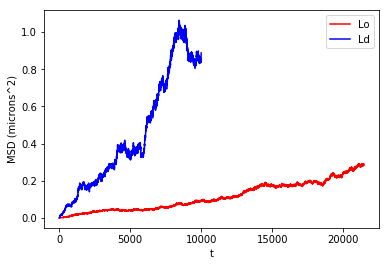

In [8]:
plt.plot(Lo_avg, 'r-', label="Lo")
plt.plot(Ld_avg, 'b-', label="Ld")

plt.xlabel("t")
plt.ylabel("MSD (microns^2)")
plt.legend()

In [9]:
#Subdiffusion happens below 1ms, which corresponds to 50 timesteps (20 microseconds each)
# np.savetxt("Ld.csv", Ld_avg)
# np.savetxt("Lo.csv", Lo_avg)

Now, fit to the MSD curve to determine the diffusion constant.

Fickian diffusion is given by $<r^2> = D t^\alpha $

In [10]:
def msd(t, D, a):
    return D * (t ** a)

# Use 1E-8 here to avoid division by zero :/
# _t = np.arange(1E-8, len(Ld_avg))
# _r = Ld_avg


traj = MSDs[LO][8]
_t = np.arange(1E-8, len(traj))
_r = traj

popt, pcov = curve_fit(msd, _t, _r, p0=(1,1))
perr = np.sqrt(np.diag(pcov))

D = 1.155e-07 +/- 3.663e-09
a = 1.592e+00 +/- 3.257e-03


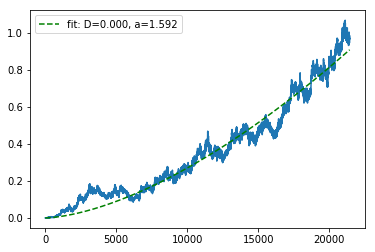

In [11]:
print('D = %5.3e +/- %5.3e' % (popt[0], perr[0]))
print('a = %5.3e +/- %5.3e' % (popt[1], perr[1]))

plt.plot(_r)
plt.plot(_t, msd(_t, *popt), 'g--', label='fit: D=%5.3f, a=%5.3f' % tuple(popt))
plt.legend()

## Try that analysis again, looking at step lengths

First, build a histogram of step lengths

In [68]:
step_lengths = []

phase = LD

for t in range(len(xs[phase])):
    _step_lengths = []
    
    # Make a list of ((x0,y0),(x1,y1),...) for this trajectory
    traj = list(zip(xs[phase][t], ys[phase][t]))
    
    # Find the square of each step length
    for i in range(1, len(traj)):
        step = (traj[i][0] - traj[i-1][0]) **2 + \
                    (traj[i][1] - traj[i-1][1]) **2
            
        _step_lengths.append( step )
    
    step_lengths.append(_step_lengths)
    
step_lengths = [y for x in step_lengths for y in x]

In [79]:
max(step_lengths)

0.003456441228360081

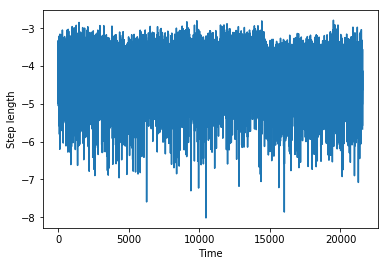

In [83]:
plt.plot(np.log10(step_lengths[::10]))
plt.xlabel("Time")
plt.ylabel("Step length")

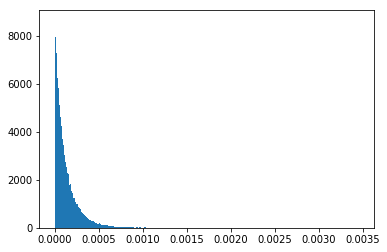

In [77]:
n, _bins, patches = plt.hist(step_lengths, bins='auto')

In [81]:
# Calculate the mean step length across all walkers
mean_step_length = np.mean(step_lengths)

print("Mean squared step length is {}".format(mean_step_length))

_D = mean_step_length/4

print("D is {}".format(_D))
print(np.std(step_lengths))

Mean squared step length is 0.0001297457184256387
D is 3.243642960640968e-05
0.00014495685517335115
